In [1]:
import itertools
import numpy as np
import networkx as nx
from tqdm import tqdm

from br_graph_analysis import learn_br_graph, transition_matrix_from_br_graph

## Learning Best-Reply Graph Structure

Define a simple team problem, and the learning parameters for the algorithm.

In [2]:
# PARAMETERS

# GAME PARAMETERS
n_states = 1 # number of states
n_agents = 2 # number of agents
n_Us = [2] * n_agents # number of actions per agent (both agents have two actions)
init_state = 0

betas = [0.9]*n_agents # discount factor
def transition_state(x, us): # transition function
    '''returns next state given current state and action'''
    return x

reward_matrix = np.array([[0, -1], [-1, 1]])
def reward(state, actions):
    u0, u1 = actions
    return reward_matrix[u0, u1]
reward_funcs = [reward, reward] # reward functions


# learning parameters
T = 10000 # length of exploration phaseinit_state
experimentation_probs = [0.05]*n_agents # probability of experimentation at each action (\rho)
alpha_func = lambda n: 1/n
deltas = [1e-6]*n_agents # tolerance for suboptimality

Run the algorithm to find the best-reply graph for the prisoner's dilemma game above.

In [3]:
br_graph = learn_br_graph(n_agents, n_states, n_Us, init_state, transition_state, reward_funcs, betas,
                  T, experimentation_probs, alpha_func, deltas)

100%|█████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.08s/it]


Draw the returned best-reply graph.

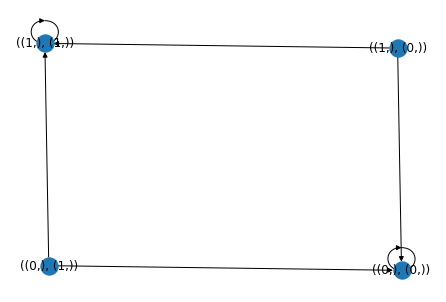

In [4]:
# draw BR graph
nx.draw_spectral(br_graph, with_labels=True)

In [5]:
# save BR graph
nx.write_gpickle(br_graph, "simple_br_graph.gpickle")

## Compute Transition Matrix from Best-Reply Graph

In [6]:
import sympy

In [7]:
# BR Process PARAMETERS
agent_inertias = [0.25, 0.75]

agent_policy_spaces = [list(itertools.product(range(n_Us[i]), repeat=n_states)) for i in range(n_agents)]
joint_policy_space = list(itertools.product(*agent_policy_spaces))

Run code to compute the transition matrix from the best-reply graph according to the agents' inertias. This was confirmed via simulation.

In [8]:
transition_matrix, jps_dict = transition_matrix_from_br_graph(br_graph, agent_inertias, joint_policy_space)
sympy.Matrix(transition_matrix).applyfunc(sympy.nsimplify) # confirmed with simulation of q-learning algorithm

Matrix([
[   1,    0,    0,    0],
[1/16, 3/16, 3/16, 9/16],
[9/16, 3/16, 3/16, 1/16],
[   0,    0,    0,    1]])

Compute the probability of the process converging/ending at each policy given each 
starting policy via $\lim_{t\to\infty}P^t$. This was also confirmed via simulation.\\

For example, if starting at policy $2$, there is a $3/4$ probability of converging to policy $0$ (the suboptimal equilibrium) and a $1/4$ probability of converging to policy $3$ (the globally optimal equilibrium).

In [9]:
end_probs_matrix = np.round(np.linalg.matrix_power(transition_matrix, 100), 4)
sympy.Matrix(end_probs_matrix).applyfunc(sympy.nsimplify)

Matrix([
[  1, 0, 0,   0],
[1/4, 0, 0, 3/4],
[3/4, 0, 0, 1/4],
[  0, 0, 0,   1]])